# Part 4 - Hybrid Cloud + On-Premises Model Serving + Model Monitoring

### Initialize MLRun Project

In [1]:
# MLRun imports
import os
from mlrun import get_or_create_project, code_to_function

# Create MLRun project
project = get_or_create_project(name="azure-fs-demo", context="./")

> 2022-02-18 02:00:49,110 [info] loaded project azure-fs-demo from MLRun DB


### Code to Function

In [2]:
serving_fn = code_to_function(
    name='model-serving',
    kind='serving',
    filename="azure_serving.py",
    image="mlrun/mlrun",
    requirements="requirements.txt"
)

### Set Model Router Topology

In [3]:
serving_fn.set_topology(
    topology='router',
    class_name='mlrun.serving.routers.EnrichmentVotingEnsemble',
    name='VotingEnsemble',
    feature_vector_uri="heart_disease_vec",
    impute_policy={"*": "$mean"}
)

### Add Models

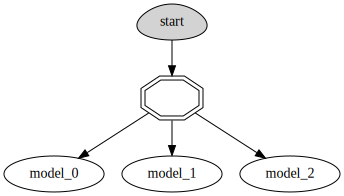

In [4]:
serving_fn.add_model(
    key="model_0",
    class_name="ClassifierModel",
    model_path="store://models/azure-fs-demo/model_0_svcwrapper#0:latest"
)
serving_fn.add_model(
    key="model_1",
    class_name="ClassifierModel",
    model_path="store://models/azure-fs-demo/model_1_logisticregression#0:latest"
)
serving_fn.add_model(
    key="model_2",
    class_name="ClassifierModel",
    model_path="store://models/azure-fs-demo/model_2_logisticregression#0:latest"
)

# Plot the ensemble configuration
serving_fn.spec.graph.plot()

### Test Locally in Jupyter Notebook

In [5]:
from azure_serving import ClassifierModel

local_server = serving_fn.to_mock_server()

> 2022-02-18 02:01:06,596 [info] model model_0 was loaded
> 2022-02-18 02:01:06,684 [info] model model_1 was loaded
> 2022-02-18 02:01:06,766 [info] model model_2 was loaded


In [6]:
local_server.test(
    path='/v2/models/infer',
    body={
        'inputs': [
            ["d107db82-fe26-4c02-b264-a3749510ed9b"]
        ]
    }
)

Input -> [[0, 0, 1, 0, 62, 0, 1, 1, 0, 0, 0, 138, 294, 0, 1, 1, 106, 1, 0, 1.9, 0, 0, 1, 3.0, 0, 1, 0]]Input -> [[0, 0, 1, 0, 62, 0, 1, 1, 0, 0, 0, 138, 294, 0, 1, 1, 106, 1, 0, 1.9, 0, 0, 1, 3.0, 0, 1, 0]]

Input -> [[0, 0, 1, 0, 62, 0, 1, 1, 0, 0, 0, 138, 294, 0, 1, 1, 106, 1, 0, 1.9, 0, 0, 1, 3.0, 0, 1, 0]]


{'id': '1dc72565f9514cd982f64735f2232d83',
 'model_name': 'VotingEnsemble',
 'outputs': [0],
 'model_version': 'v1'}

### Enable Model Monitoring

In [7]:
serving_fn.set_tracking()
project.set_model_monitoring_credentials(os.getenv('V3IO_ACCESS_KEY'))

### Deploy on Kubernetes Cluster

In [8]:
serving_fn.deploy()

> 2022-02-18 02:01:09,933 [info] Starting remote function deploy
2022-02-18 02:01:12  (info) Deploying function
2022-02-18 02:01:12  (info) Building
2022-02-18 02:01:13  (info) Staging files and preparing base images
2022-02-18 02:01:13  (info) Building processor image
2022-02-18 02:03:39  (info) Build complete
2022-02-18 02:03:48  (info) Function deploy complete
> 2022-02-18 02:03:49,419 [info] successfully deployed function: {'internal_invocation_urls': ['nuclio-azure-fs-demo-model-serving.default-tenant.svc.cluster.local:8080'], 'external_invocation_urls': ['azure-fs-demo-model-serving-azure-fs-demo.default-tenant.app.us-sales-32.iguazio-cd0.com/']}


'http://azure-fs-demo-model-serving-azure-fs-demo.default-tenant.app.us-sales-32.iguazio-cd0.com/'

In [9]:
serving_fn.invoke(
    path='/v2/models/infer',
    body={
        'inputs': [
            ["d107db82-fe26-4c02-b264-a3749510ed9b"],
            ["4d05f307-b699-4dbe-b51d-f14627233e5a"],
            ["43f23da3-99d0-4630-9831-91d7b54e757e"],
            ["e031ed66-52f8-4f49-9881-aeff00be2be1"],
            ["31ff724d-b29b-4edb-9f70-f4da66902fe2"]
        ]
    }
)

> 2022-02-18 02:03:52,717 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-azure-fs-demo-model-serving.default-tenant.svc.cluster.local:8080/v2/models/infer'}


{'id': '23b50790-8a94-436d-a10c-866d1ec2fb67',
 'model_name': 'VotingEnsemble',
 'outputs': [0, 1, 1, 0, 1],
 'model_version': 'v1'}

### Get Records to Simulate Traffic

In [10]:
import mlrun.feature_store as fstore

In [11]:
records = fstore.get_offline_features(
    feature_vector="azure-fs-demo/heart_disease_vec",
    with_indexes=True
).to_dataframe().index.to_list()

### Simulate Production Traffic

In [ ]:
from random import choice, uniform
from time import sleep

# Sending random requests
for _ in range(4000):
    data_point = choice(records)
    try:
        resp = serving_fn.invoke(path='/v2/models/predict', body={'inputs': [[data_point]]})
        print(resp)
        sleep(uniform(0.2, 1.7))
    except OSError:
        pass